In [3]:
from IPython import get_ipython
from IPython.display import display
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import random
from shutil import copyfile

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
base_dir = '/content/drive/MyDrive/cat vs loaf'
!ls "/content/drive/MyDrive/cat vs loaf"

bahan  latih  validasi


In [6]:
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [7]:
cat_dir = os.path.join(bahan_dir, 'cat/')
loaf_dir = os.path.join(bahan_dir, 'loaf/')

print("Jumlah Data cat vs loaf")
print('total cat images:', len(os.listdir(cat_dir)))
print('total loaf images:', len(os.listdir(loaf_dir)))

Jumlah Data cat vs loaf
total cat images: 51
total loaf images: 51


In [8]:
# Direktori isi training
train_cat = os.path.join(train_dir, 'cat/')
train_loaf = os.path.join(train_dir, 'loaf/')

# direktori isi validasi
validation_cat = os.path.join(validation_dir, 'cat/')
validation_loaf = os.path.join(validation_dir, 'loaf/')

In [9]:
def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(total_size * train_ratio)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  os.makedirs(train, exist_ok=True)
  os.makedirs(val, exist_ok=True)

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.9

source_00 = cat_dir
train_00 = train_cat
val_00 = validation_cat
train_val_split(source_00, train_00, val_00, train_ratio)


source_01 = loaf_dir
train_01 = train_loaf
val_01 = validation_loaf
train_val_split(source_01, train_01, val_01, train_ratio)

In [10]:
print('Jumlah data all cat:', len(os.listdir(cat_dir)))
print('Jumlah data latih cat:', len(os.listdir(train_cat)))
print('jumlah val cat       :', len(os.listdir(validation_cat)))

Jumlah data all cat: 51
Jumlah data latih cat: 51
jumlah val cat       : 51


In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'sparse'  # Changed class_mode to 'sparse'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'sparse'  # Changed class_mode to 'sparse'
)

Found 102 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [27]:
model = tf.keras.models.Sequential ([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed =112),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=112),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       1,849,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,970,694 (7.52 MB)

 Trainable params: 1,970,694 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=25,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4076 - loss: 0.7812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4015 - loss: 0.7808 - val_accuracy: 0.6000 - val_loss: 0.6919
Epoch 2/25
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4603 - loss: 0.7033

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.4603 - loss: 0.7030 - val_accuracy: 0.3000 - val_loss: 0.6977
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - accuracy: 0.5891 - loss: 0.6899 - val_accuracy: 0.3000 - val_loss: 0.7113
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.4742 - loss: 0.6997 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5869 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 705ms/step - accuracy: 0.5497 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.3371 - loss: 0.7306 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.5603 - loss: 0.6820 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 902ms/step - accuracy: 0.4452 - loss: 0.6962 - val_accuracy: 0.3000 - val_loss: 0.7028
Epoc

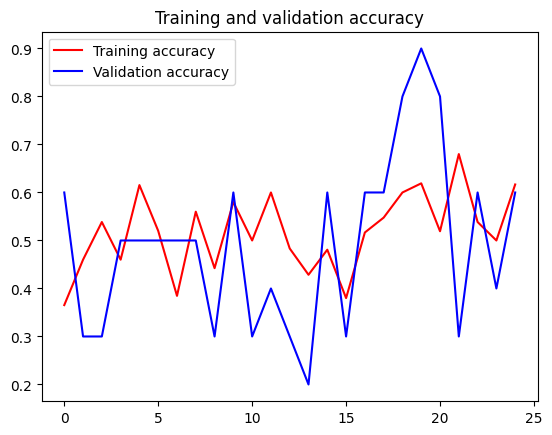

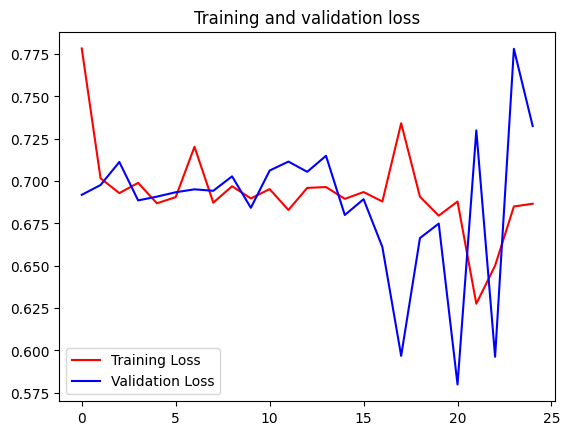

In [39]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

Saving loaf (22).jpg to loaf (22).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
loaf (22).jpg
This image belongs to class cat


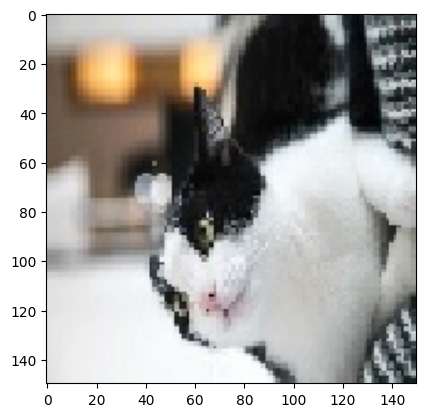

In [55]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  class_list = os.listdir(train_dir)

  predicted_class_index = np.argmax(classes[0])
  print('This image belongs to class', class_list[predicted_class_index])